# AWS Sagemaker Image Classification of Dog Breed 

This notebook shows how to do image classification with a pre-trained model in AWS Sagemaker.
We use a pretrained convolutional neural network with 50 layers (resnet50) in Pytorch Vision. The CNN is improved by using residual learning that shortcuts connections by skipping layers.

The model is fine-tuned to our image data set, consisting of dog images labelled by breed. 
This is done using a hyper parameter job to train it in Sagemaker. 
Finally, we enable profiling and debugging with hooks to track the progress of our model training. Ultimately, we obtain a supervised image classifier that can tell the breed of dogs.

Debugging helps troubleshoot the training of our neural network (e.g., vanishing/exploding gradients, bad weight initialization, saturated activation, overfitting, class imbalance, loss).

Profiling helps create a report while training that tracks the progress of our model training.
Finally, profiling can help measure GPU, CPU, and memory utilization. 

In [15]:
# Install packages 
# We will need the smdebug package|
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [4]:
# Import packages that we need
# For instance, we will Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role

In [5]:
# Set up role, sagemaker, and s3 bucket 
role = get_execution_role()
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
print(f"Region {region} and S3 Bucket: {bucket}")

Region us-west-1 and S3 Bucket: sagemaker-us-west-1-625155689245


## Dataset

We are using an image data set of dogs that are labelled by their breed, which can be 133 different kinds. 

In [ ]:
# Command to download and unzip data (NB: only run once) 
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
# Fetch and upload the data to AWS S3 (NB: only run once)
image_data_folder_path ="dogImages"
s3_file_path = session.upload_data(path=image_data_folder_path, bucket=bucket, key_prefix=image_data_folder_path)
print(f"S3 File Path: {s3_file_path}")

In [11]:
s3_file_path = "s3://sagemaker-us-west-1-625155689245/dogImages"

## Hyperparameter Tuning

We will finetune a pretrained model with hyperparameter tuning. 
We need to tune at minimum two hyperparameters.
Optionally, we can explain why we pick those hyperparameters and ranges.

To do finetuning (i.e., transfer learning), we will add a fully connected neural network layer on top of the pretrained model as the output layer, which can perform classification of 133 breeds. 


We use the Adam optimizer (with adaptive learning rate) from Pytorch and the following hyperparameters:
- Learning rate: 0.000001 (10^-6) to 1.0 (10^0) 
- Epsilon: 1 to 3 
- Weight decay: 0 to 0.1 (1e-1) 

The learning rate controls the step size at which we move in the direction towards the minimum of a loss function during each training iteration. Epsilon controls the threshold at which we automatically discard redundant layers that produce responses smaller than this threshold: [epsilon-ResNet](https://arxiv.org/abs/1804.01661). Namely, epsilon controls the tradeoff between accuracy and network size and is typically in the 1-3 range. The weight decay is a regularizing term controlling the weights by penalizing/shrinking them during backprogation to avoid overfitting. It is usually set between 0 and 0.1: [ML Mastery](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/). 

The ranges are picked randomly through trial and error experimentation and rough guidelines. 

Typical values for a neural network with standardized inputs (or inputs mapped to (0, 1) interval) are less than 1 and greater than 10^-6: [ML Mastery](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/). 

**Note:** We will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
# Declare HP ranges, metrics etc.
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.000001, 1.0),
    "eps": ContinuousParameter(1, 3),
    "weight_decay": ContinuousParameter(0, 0.1),
    "batch_size": CategoricalParameter([64, 128]), # Picked range similar to exercises for speedup
}

objective_metric_name = "avg_test_loss"
objective_type = "Minimize" 
metric_definitions = [{"Name": objective_metric_name, "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
# Create estimator for our HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py", # Hyper parameter entry point for training 
    base_job_name = "sagemaker-dog-breed-image-classification-hyperparameter-tuning",
    role = role,
    instance_count = 1, 
    instance_type = "ml.g4dn.xlarge", # if ml.g4dn.xlarge (4 CPU, 16GB RAM, GPU) not working try ml.m5.xlarge  
    py_version = "py36", 
    framework_version = "1.8"
) 

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions, # Extracts average loss from logs with regex
    max_jobs=1, # Max train jobs 
    max_parallel_jobs=1, # Max parallel training jobs to start
    objective_type=objective_type,
    early_stopping_type="Auto" # Early stopping may happen 
)

In [34]:
# Fit your HP Tuner
tuner.fit({"training": s3_file_path }, wait=True) # Remember to include your data channels

...........................................................................................................................................................................!


In [ ]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

In [36]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best hyperparameters : \n {best_hyperparameters}")

Best hyperparameters : 
 {'batch_size': 128, 'eps': '2.8673436008071853', 'lr': '0.0017412062280646723', 'weight_decay': '0.005611348748266832'}


In [8]:
best_hyperparameters = {'batch_size': 128, 'eps': '2.8673436008071853', 'lr': '0.0017412062280646723', 'weight_decay': '0.005611348748266832'}

## Model Profiling and Debugging
We use the best hyperparameters to create and finetune a new model

**Note:** We will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# Set up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [12]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", # 1.6 supports smdebug lib
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include profiler hook
    debugger_hook_config=debugger_config, # include debugger hook
    rules=rules
)

estimator.fit({'train' : s3_file_path },wait=True)

2022-04-08 16:26:17 Starting - Starting the training job...
2022-04-08 16:26:46 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-04-08 16:27:46 Downloading - Downloading input data............
2022-04-08 16:29:47 Training - Downloading the training image...
2022-04-08 16:30:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-08 16:30:16,952 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-08 16:30:16,980 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-08 16:30:16,987 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-08 16:30:17,362 sagemaker-training-toolkit INFO     Invo

In [13]:
#fetch job name, client and description for plotting
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-04-08-16-26-16-613
Client: <botocore.client.SageMaker object at 0x7f7dfa46aa90>
Description: {'TrainingJobName': 'pytorch-training-2022-04-08-16-26-16-613', 'TrainingJobArn': 'arn:aws:sagemaker:us-west-1:625155689245:training-job/pytorch-training-2022-04-08-16-26-16-613', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"2.8673436008071853"', 'lr': '"0.0017412062280646723"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-04-08-16-26-16-613"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-west-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/source/sourcedir.tar.gz"', 'weight_decay': '"0.005611348748266832"'}, 'AlgorithmSpecifica

In [16]:
# Trail object to query for tensors in given training job, based on smdebug artifact path 
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-04-08 16:39:35.830 datascience-1-0-ml-t3-medium-0943ed5e601f607095bd0313c49c:107 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-08 16:39:35.842 datascience-1-0-ml-t3-medium-0943ed5e601f607095bd0313c49c:107 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/debug-output


loaded training data
loaded test data
Completed training plot
Completed testing plot


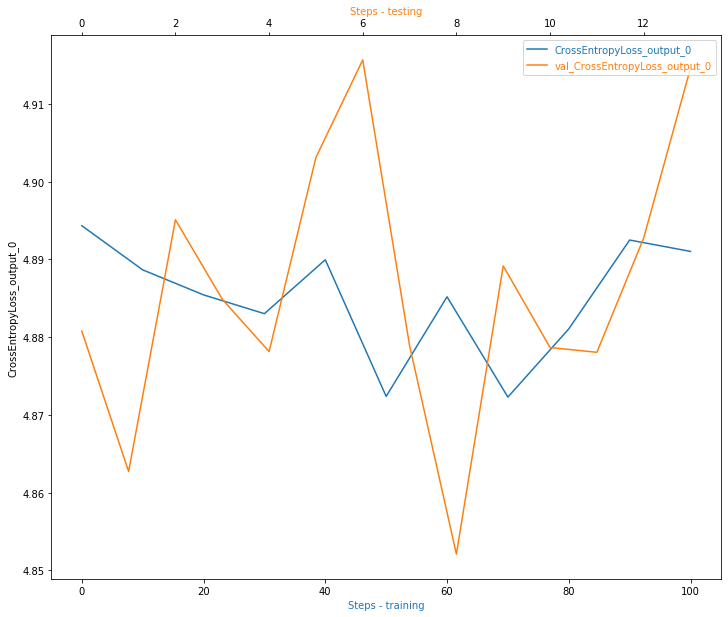

In [18]:
# Plot a debugging output
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

# helper to get data from tensors
def get_data_from_tensors(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    values = []
    for s in steps:
        values.append(tensor.value(s, mode=mode))
    return steps, values

# helper to plot tensor values over time 
def plot_tensor(trial, tensor_name):

    training_steps, training_values = get_data_from_tensors(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded training data")
    test_steps, test_values = get_data_from_tensors(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded test data")

    fig = plt.figure(figsize=(12, 10))
    host = host_subplot(111)
    par = host.twiny()
    host.set_xlabel("Steps - training")
    par.set_xlabel("Steps - testing")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(training_steps, training_values, label=tensor_name)
    print("Completed training plot")
    (p2,) = par.plot(test_steps, test_values, label="val_" + tensor_name)
    print("Completed testing plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())
    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
- The loss is not smooth but very spiky. 
- Using batches of data with shuffling might help stabilize it or trying a different neural network architecture setup. 

In [19]:
# Display the profiler output
profiler_report_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {profiler_report_path}")

Profiler report location: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output


In [20]:
! aws s3 ls {profiler_report_path} --recursive

2022-04-08 16:36:24     371898 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-08 16:36:24     227804 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-08 16:36:20        191 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-08 16:36:20      19638 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-08 16:36:20        126 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-04-08 16:36:20        129 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-04-08 16:36:20       3029 pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {profiler_report_path} ./ --recursive

download: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-west-1-625155689245/pytorch-training-2022-04-08-16-26-16-613/rule-output/ProfilerReport/prof

In [22]:
import os
# get auto generated profiler report folder name
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [23]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [24]:
# Zip profiler report for submission
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/aws-ml-engineer-sagemaker-nanodegree/3 - Image Classification/profiler_repot.zip.zip'

## Model Deploying

In [25]:
# Deploy our model to an endpoint
# Add your deployment configuration like instance type and number of instances
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

-----!

In [ ]:
# Run a prediction on the endpoint
# Our code to load and preprocess image to send to endpoint for prediction
from PIL import Image
import os
import io
import numpy as np
test_dir = "./dogImages/test/"
test_img = "011.Australian_cattle_dog/Australian_cattle_dog_00727.jpg"
expected_label = 11 
test_file_path = os.path.join(test_dir, test_img)
with open(test_file_path , "rb") as f:
    image = f.read()
    print("Testing image")
    display(Image.open(io.BytesIO(image)))
    print(f"Expected dog breed label: {expected_label}")
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    predicted_dog_breed = np.argmax(response, 1) + 1 # Index starts from 0 as prediction is 0-indexed
    print(f"Response/Inference for the above image is : {predicted_dog_breed}")

response = predictor.predict(image)

In [ ]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()